In [ ]:
#Import packages. Feel free to add any others you might use!
import itertools
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random as jrandom
from jax import nn as jnn
import random
import time
import math
from jax import jit
import numpy as np

# Project 1

By: Alison Siaw & Sam Vermeulen

# Problem 1 - Simulating a Markov chain with uniform random variables

The probability that a uniform random variable will be in between intervals generated by a cumulative sum of a probability vector is the probability of transitioning between states.

**For example:** If we have the probability vector $[0.3, 0.2, 0.5]$. The cumulative sum vector will be $[0.3, 0.5, 1.0]$. Then a uniform random variable in the interval $[0, 1]$. Has $0.3$ probability to be in the interval $[0.0, 0.3]$, a $0.2$ probability to be in the interval $[0.3, 0.5]$, and a $0.5$ probability to be in the interval $[0.5, 1.0]$. In these cases we would transition to states 0, 1, or 2 respectively.

In [ ]:
def Markov_chain_sim(P,X_0,U, tests=False):
  '''Given X_0 and the transition matrix P, gives a possible X_1 
     using a uniform [0,1] random variable'''
  #Input: 
  #  P = An array of shape (N,N) where the entries are non-negative and each row sums to 1  
  #  x_0 = An integer from the state space [0,N-1]
  #  U = A real number between [0,1] which is generated as a uniform random variable
  #Ouput:
  #  An integer from the state space [0,N-1] which gives the location of the Markov chain at time X_1

  # note: this function can also take in an array of uniform random variables and will return an array of X_1's

  if tests:
    assert(np.all(np.sum(P,axis=1) == 1))

  # searchsorted is used to find indicdes in a sorted array such that the order of the original array would still be preserved
  # position is assigned to searchsorted passing the sorted cumulative sum and random variable U as parameter

  # the cumulative sum of the transitions from state X_0
  transition_cumsum = np.cumsum(P[X_0])

  # finds the position in the transition_cumsum that the random variable U should
  # be placed to maintain the order. This is the state we should transition to.
  position = np.searchsorted(transition_cumsum, U)

  # return the position(s) in the array to the left where random variable(s) U should be inserted
  return position

## Problem 1 - Tests

These are just tests we performed while working on this problem.

In [ ]:
def test_Markov_chain_sim_distribution(transition_matrix, num_runs):
  #Purpose:
  # Used to visually check the distribution of the Markov chain simulation
  #Input:
  # transition_matrix - the test matrix
  # num_runs - the number of simulations to run on each state of the transition_matrix
  # print_transition_matrix - flag tells function to display the transition matrix 

  print("Expected Distribution:\n", transition_matrix*num_runs)

  results = np.zeros(transition_matrix.shape)
  for i in range(len(transition_matrix[0])):
    (uq, counts) = np.unique(Markov_chain_sim(transition_matrix, i, np.random.uniform(size=num_runs)), return_counts=True)
    results[i][uq] = counts

  print("\nResults:\n", results)

def test_Markov_chain_sim_choices():
  transition_matrix = np.array([[0.3, 0.2, 0.5],
                                [0.1, 0.4, 0.5],
                                [0, 1, 0.0]])


  assert(Markov_chain_sim(transition_matrix, 0, 0.8, tests=True) == 2)
  assert(Markov_chain_sim(transition_matrix, 0, 0.001, tests=True) == 0)

  assert(Markov_chain_sim(transition_matrix, 1, 0, tests=True) == 0)
  assert(Markov_chain_sim(transition_matrix, 1, 0.5, tests=True) == 1)
  assert(Markov_chain_sim(transition_matrix, 1, 0.8, tests=True) == 2)

  assert(Markov_chain_sim(transition_matrix, 2, 0.001, tests=True) == 1)
  assert(Markov_chain_sim(transition_matrix, 2, 0.5, tests=True) == 1)
  assert(Markov_chain_sim(transition_matrix, 2, 0.999, tests=True) == 1)

%time test_Markov_chain_sim_distribution(jnp.array([[0, 0.25, 0, 0, 0.75], [0, 0.1, 0, 0, 0.9], [0.4, 0, 0, 0, 0.6], [0, 0, 0.5, 0.5, 0], [0, 0, 0.3, 0.7, 0]]), 10_000_000)

test_Markov_chain_sim_choices()

Expected Distribution:
 [[      0. 2500000.       0.       0. 7500000.]
 [      0. 1000000.       0.       0. 9000000.]
 [4000000.       0.       0.       0. 6000000.]
 [      0.       0. 5000000. 5000000.       0.]
 [      0.       0. 3000000. 7000000.       0.]]

Results:
 [[      0. 2497843.       0.       0. 7502157.]
 [      0. 1000655.       0.       0. 8999345.]
 [3997036.       0.       0.       0. 6002964.]
 [      0.       0. 4998144. 5001856.       0.]
 [      0.       0. 2999650. 7000350.       0.]]
CPU times: user 4.09 s, sys: 231 ms, total: 4.32 s
Wall time: 6.46 s


# Problem 2 - A weather model

## 2a Solution

For this Markov chain we will use the state space $S = \{RR, RRR, SR, SS, RS\}$ such that,

\begin{align*}
    RR \text{ (state 0) } &= \text{it is rainy today and yesterday} \\
    RRR \text{ (state 1) } &= \text{it is rainy three days in a row} \\
    SR \text{ (state 2) } &= \text{it is rainy today and sunny yesterday} \\
    SS \text{ (state 3) } &= \text{it is sunny today and yesterday} \\
    RS \text{ (state 4) } &= \text{it is sunny today but rainy yesterday}
\end{align*}

Note that our states are ordered chronological from left to right (backwards from textbook and class notes).

Using the rules layed out in the project description we get the following transition matrix for our Markov chain,

\begin{align*}
    P =
    \begin{bmatrix}
        0 & 0.25 & 0 & 0 & 0.75 \\
        0 & 0.1 & 0 & 0 & 0.9 \\
        0.4 & 0 & 0 & 0 & 0.6 \\
        0 & 0 & 0.5 & 0.5 & 0 \\
        0 & 0 & 0.3 & 0.7 & 0
    \end{bmatrix} \tag{1}
\end{align*}

To get the probability that it is one of these states on various days, we will use the probabilty vectors at time $n$,

\begin{align}
  \vec{v}_n=[P(X_n=RR),P(X_n=RRR),P(X_n=SR),P(X_n=SS),P(X_n=RS)] \tag{2}
\end{align}

The formula to update the probability vector is as follows:

\begin{align}
  \vec{v}_n = \vec{v}_0P^n \tag{3}
\end{align}

There are 3 states $(RR, RRR, SR)$ in which it is rainy on a given day. So to calculate the probability that it is rainy on various days we need to sum the probability that it is one of these states.

\begin{align}
  P(X_n=\text{Rainy})=P(X_n=RR)+P(X_n=RRR)+P(X_n=SR) \tag{4}
\end{align}

Directed graph of the Markov Chain:


<div align="center">

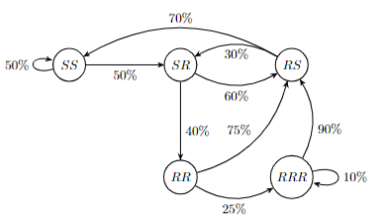
</div>

## 2b Solution


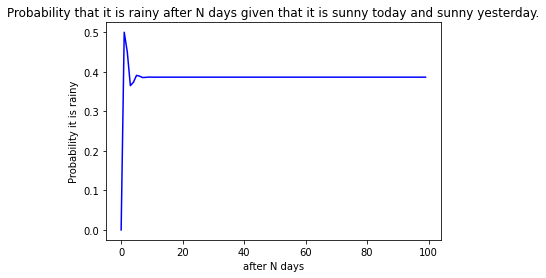

In [ ]:
def sum_rainy_probabilities(v):
  #Purpose: 
  # Finds the probability that it is rainy from a
  # given probabilty vector as in equation (4)
  #Input:
  # v = the probability vector
  #Output:
  # a real number which is the probabilty that it is rainy
  return v[0] + v[1] + v[2]

def rainy_probability(n, tests=False):
  #Purpose: Find the exact probability on day n given that is sunny today and sunny yesterday
  #Input: 
  #  n = integer number of days in the future
  #Output:
  # A single number which is the probabaility it is rainy on day n

  # initial probability vector is [0, 0, 0, 1, 0] by equation (2) since it is sunny today and sunny yesterday
  v_0 = jnp.array([0, 0, 0, 1, 0])

  # create the transition matrix from equation (1)
  transition_matrix = jnp.array([[0, 0.25, 0, 0, 0.75], 
                                 [0, 0.1, 0, 0, 0.9], 
                                 [0.4, 0, 0, 0, 0.6], 
                                 [0, 0, 0.5, 0.5, 0], 
                                 [0, 0, 0.3, 0.7, 0]])
  
  
  # get the probability vector on day n by equation (3)
  v_n = jnp.matmul(v_0, jnp.linalg.matrix_power(transition_matrix, n))

  if tests:
    print("transition_matrix:\n", transition_matrix)
    print("v_n:", v_n)

  # get rainy probability on day n as in equation (4)
  return sum_rainy_probabilities(v_n)

def graph_day_rainy_probability_for_n_days(n):
  #Purpose:
  # Creates a plot of the rainy probability over n days
  #Input:
  # The number of days to plot
  prob_arr = jnp.zeros(n)
  for i in range(n):
    prob_arr = prob_arr.at[i].set(rainy_probability(i))

  plt.plot(prob_arr, 'b')
  plt.title('Probability that it is rainy after N days given that it is sunny today and sunny yesterday.')
  plt.ylabel('Probability it is rainy')
  plt.xlabel('after N days')
  plt.show()

graph_day_rainy_probability_for_n_days(100)

## 2c Solution

To find the stationary distribution, $\vec{v}_\infty = (a, b, c, d, e)$, of the Markov chain we need to solve the following eigenvector problem with eigenvalue 1 

\begin{align}
  \vec{v}_{\infty}
  =
  \vec{v}_{\infty}
  P \tag{5}
\end{align}

This will give us the following system of linear equations,

\begin{align}
  a &= 0.4c\\
  b &= 0.25b + 0.10c\\
  c &= 0.50d + 0.30e\\
  d &= 0.50d + 0.70e\\
  e &= 0.75a + 0.90b + 0.60c\\
\end{align}

subject to $1 = a + b + c + d + e$. If we put all of these together and move all of the variables to the right hand side, we get the following system of linear equations:

\begin{align}
  \begin{cases}
    0 &= -a + 0.4c\\
    0 &= -0.75b + 0.10c\\
    0 &= -c + 0.50d + 0.30e\\
    0 &= -0.50d + 0.70e\\
    0 &=  0.75a + 0.90b + 0.60c-e \\
    1 &= a + b + c + d + e \\
  \end{cases}\tag{6}
\end{align}

This system is not invertible so it cannot be solved with the numpy solve function. However it is redudant and we can get rid of one of the equations.

\begin{align}
  \begin{cases}
    0 &= -a + 0.40c\\
    0 &= -0.75b + 0.1c\\
    0 &= -c + 0.50d + 0.30e\\
    0 &= -0.50d + 0.70e\\
    1 &= a + b + c + d + e\\
  \end{cases}\tag{7}
\end{align}

This linear system is represented by the equation in matrix form as:

\begin{align}
  \begin{bmatrix}
    -1 & 0 & 0.4 & 0 & 0\\
    0 & -0.75 & 0.1 & 0 & 0\\
    0 & 0 & -1 & 0.5 & 0.3\\
    0 & 0 & 0 & -0.5 & 0.7\\
    1 & 1 & 1 & 1 & 1\\
  \end{bmatrix}
  \begin{bmatrix}
    a\\b\\c\\d\\e
  \end{bmatrix}
  =
  \begin{bmatrix}
    0\\0\\0\\0\\1
  \end{bmatrix}\tag{8}
\end{align}


This can be solved using the numpy solve function and we get 

\begin{align*}
  \begin{cases}
    a &= 0.10169493\\
    b &= 0.03389826\\
    c &= 0.25237320\\
    d &= 0.35593220\\
    e &= 0.25423726
  \end{cases}\tag{9}
\end{align*}

To get the probability that it is rainy today we need to sum the probabilities of states that are rainy today as in equation (4)


In [ ]:
def limit_rainy_probability(tests=False):
  #Purpose: Find the exact limiting probability it is rainy in the far future
  #Output: 
  # A single number which is the value of the limit
  
  # sets up the matrix as in equation (8)
  A = jnp.array([[-1, 0, .4, 0, 0],
                 [0, -.75, .1, 0, 0],
                 [0, 0, -1, .5, .3],
                 [0, 0, 0, -.5, .7],
                 [1, 1, 1, 1, 1]])
   
  # sets up the solution vector as in equation (8)
  b = jnp.array([0,0,0,0,1])

  # solve the system in equation (8) to get the solution in (9)
  v_inf = jnp.linalg.solve(A,b)

  if tests: 
    print("v_inf:", v_inf)
    assert(jnp.sum(v_inf) == 1)

  # get the rainy probability as in equation (4)
  return sum_rainy_probabilities(v_inf)

limit_rainy_probability()

DeviceArray(0.38983053, dtype=float32)

## Problem 2 - Tests

These are just tests we performed while working on this problem.

In [ ]:
def test_sum_rainy_probabilities():
  #Purpose:
  # Tests the sum_rainy_probabilities function

  assert(sum_rainy_probabilities(np.array([0.3, 0.2, 0.1, 0, 0])) == 0.6)
  assert(sum_rainy_probabilities(np.array([0.0, 1, 0, 0, 0])) == 1.0)
  assert(sum_rainy_probabilities(np.array([0,0,0,0.5,0.5])) == 0.0)
  assert(sum_rainy_probabilities(np.array([-0.5, 0.5, 0.0, 0, 0])) == 0.0)

def test_rainy_probability():
  #Purpose:
  # Tests the rainy_probability function and the limit_rainy_probability function

  assert(rainy_probability(1) == sum_rainy_probabilities(np.array([0, 0, 0.5, 0.5, 0])))
  assert(rainy_probability(2) == 0.45)
  assert(rainy_probability(100) == 0.38636386)
  assert(np.isclose(rainy_probability(1500000, tests=True), limit_rainy_probability(tests=True),atol=1e-3))

test_sum_rainy_probabilities()
test_rainy_probability()

transition_matrix:
 [[0.   0.25 0.   0.   0.75]
 [0.   0.1  0.   0.   0.9 ]
 [0.4  0.   0.   0.   0.6 ]
 [0.   0.   0.5  0.5  0.  ]
 [0.   0.   0.3  0.7  0.  ]]
v_n: [0.10310315 0.02863976 0.25775784 0.36086097 0.25775784]
v_inf: [0.10169493 0.03389826 0.25423732 0.3559322  0.25423726]


#Problem 3 - Monkey at a typewriter

## 3a Solution

Using this as a Markov Chain would be difficult for the computer to handle because the state space of the problem would be $n_{buttons}^{n_{word}}$. This state space will grow extremely fast as $n_{buttons}$ or $n_{word}$ grows.

## 3b Solution

Consider using the state space of subsequences of words starting with the first button in the given **word sequence** $\vec{w}$ and one other state that represents the monkey pressing a button that is not the next button in the **word sequence**.

**For example**, if our **word sequence** is **012** and we have 4 buttons $(0, 1, 2, 3)$. Our state space would be as follows:

\begin{align*}
  \mathcal{S} = \{0, 01, 012, \text{'not in sequence'}\}
\end{align*}

Let $X_t$ be the state at time t, then the transition probability are as follows:

* $\mathbb{P}(X_t = 0 | X_{t-1} = \text{NIS}) = \frac{1}{4}$
* $\mathbb{P}(X_t = \text{NIS} | X_{t-1} = \text{NIS}) = \frac{3}{4}$
* $\mathbb{P}(X_t = 01 | X_{t-1} = 0) = \frac{1}{4}$
* $\mathbb{P}(X_t = \text{NIS} | X_{t-1} = 0) = \frac{2}{4}$
* $\mathbb{P}(X_t = 0 | X_{t-1} = 0) = \frac{1}{4}$
* $\mathbb{P}(X_t = 012 | X_{t-1} = 01) = \frac{1}{4}$
* $\mathbb{P}(X_t = \text{NIS} | X_{t-1} = 01) = \frac{2}{4}$
* $\mathbb{P}(X_t = 0 | X_{t-1} = 01) = \frac{1}{4}$

Note: All other transitions are probability $0$, and $012$ is a terminal state

##3c Solution

The expected amount of time for the sequences [0, 0] and [0, 1] to appear would not be the same. The expected time for the sequence [0, 1] will be lower because there is a chance that when the monkey presses a button it will not go out of sequence. For the sequence [0, 0] if the monkey presses any button other than 0 it will no longer be in sequence.

The directed graphs for the Markov chains of these sequences are almost identical, however the sequence [0, 1] has a loop on the 0 state. This will decrease the expected amount of time to type this sequence.

Directed Graph for the sequences [0,0] and [0,1]:

|[0,0]|[0,1]|
|-|-|
|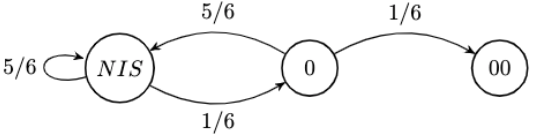|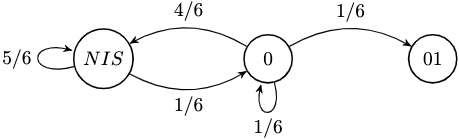|




## 3d Solution

In [ ]:
def construct_monkey_matrix(N_buttons, word_sequence, tests=False):
  #Purpose:
  #   Constructs the monkey matrix with N_buttons for a given word_sequence
  #Input: 
  #  N_buttons = An integer, number of buttons on the typewritter
  #  word_sequence = An array of shape (N_word,). Each enty is an integer in [0,N_buttons-1]
  #Output:
  #  A matrix that represents the number of possible ways to go from one state to another

  N_word = len(word_sequence)

  # initialize the transition matrix (without the
  # not in state column and row) and assigns the k=1
  # diagonal to N_word
  t = np.eye(N_word, k=1)

  # gets the indices for the lower triangle
  tl_ix = np.tril_indices_from(t)

  # flip indices to iterate backwards
  ix = (jnp.flip(tl_ix[0]), jnp.flip(tl_ix[1]))

  # set each of the possible connections in the markov chain to 1
  for x,y in np.nditer(ix):
    # check if the last few elements of the current state match
    # the first few elements of the next state
    if np.all(word_sequence[x+1-y:x+1] == word_sequence[0:y]):
      t[x,y] = 1
      # this will remove the entry if this would actually transition
      # to a state further in the word sequence
      non_zero = word_sequence[np.nonzero(t[x])]
      if len(np.unique(non_zero)) != len(non_zero):
        t[x,y] = 0

  # expands the matrix to include the NIS column and row,
  # calculate the left most column of the matrix and initialize
  # the bottom row to 0, and the bottom right most element to N_buttons.
  P = np.zeros(shape=(N_word+1,N_word+1))
  P[0,1] = 1
  P[1:,1:] = t
  P[:, 0] = N_buttons - P.sum(axis=1)
  P[-1:, :] = 0
  P[-1:, -1:] = N_buttons

  if tests:
    print("monkey matrix:\n", P)
    assert(np.all(np.sum(P, axis=1) == N_buttons)) # rows should sum to N_buttons

  return P

def expected_monkey_time(N_buttons, word_sequence, tests=False):
  #Purpose:
  #   Returns the expected amount of time for the monkey to type the word
  #Input: 
  #  N_buttons = An integer, number of buttons on the typewritter
  #  word_sequence = An array of shape (N_word,). Each enty is an integer in [0,N_buttons-1]
  #Output:
  #  A real number which is the expected time until the word appears

  if tests:
    assert(N_buttons >= len(np.unique(word_sequence)))

  # construct the monkey_matrix - this is not a transition matrix
  # because i am using the number of buttons you can press
  # that will get you from one state to another.
  monkey_matrix = construct_monkey_matrix(N_buttons, word_sequence, tests)
  N_word = len(word_sequence)

  # find the expected time to write the given word_sequence
  # beginning in the NIS state.
  v = np.ones(N_word+1)
  v[-1] = 0
  
  M = np.eye(N_word+1)*N_buttons - monkey_matrix
  M[-1,-1] = N_buttons

  if tests:
    assert(np.all(np.sum(M[:-1,:],axis=1) == 0))
    assert(np.all(np.sum(M[-1]) == N_buttons))

  # convert counts to probabilities
  M=M/N_buttons

  return np.linalg.solve(M,v)[0]

expected_monkey_time(10, np.array([1,2,3,1,2,3,1,2]))

100100100.01078396

In [ ]:
print(expected_monkey_time(5, np.array([0,0,0])))

155.00000000000028


## Problem 3 - Tests
There are just tests we performed while working on this problem.

In [ ]:
def test_expected_monkey_time(tests=False):
  assert(np.isclose(expected_monkey_time(10, np.array([1,2,3,1,2,3,1,2]), tests), 100100100))
  assert(np.isclose(expected_monkey_time(6, np.array([1,2,3]), tests), 216))
  assert(np.isclose(expected_monkey_time(2, np.array([0,1,0,1,0,1]), tests), 84))
  assert(np.isclose(expected_monkey_time(200, np.array([1,1]), tests), 40200))
  assert(np.isclose(expected_monkey_time(2000, np.array([100]), tests), 2000))
  assert(np.isclose(expected_monkey_time(6, np.array([0,0]), tests), 42))
  assert(np.isclose(expected_monkey_time(6, np.array([0,1]), tests), 36))

def test_construct_monkey_matrix(tests=False):
  assert(np.all(np.sum(construct_monkey_matrix(18, np.array([1,2,1,2,3,1,6,3,10,17]), tests), axis=1) == 18))

  if False: # set to true if you want to run - it will take some time
    N_buttons = 500
    seq_len = 1000
    big_monkey_matrix = construct_monkey_matrix(N_buttons, np.random.randint(0, N_buttons-1, seq_len),tests)
    assert(np.all(np.sum(big_monkey_matrix, axis=1) == N_buttons))
    assert(big_monkey_matrix.shape == (seq_len+1,seq_len+1))
    assert(np.all(np.diagonal(big_monkey_matrix, offset=1) == 1))
    assert(np.all(np.sum(big_monkey_matrix[np.triu_indices_from(big_monkey_matrix, k=2)]) == 0))

test_expected_monkey_time(tests=True)
test_construct_monkey_matrix(tests=True)

monkey matrix:
 [[ 9.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 8.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 8.  1.  0.  1.  0.  0.  0.  0.  0.]
 [ 9.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 8.  1.  0.  0.  0.  1.  0.  0.  0.]
 [ 8.  1.  0.  0.  0.  0.  1.  0.  0.]
 [ 9.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 8.  1.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 10.]]
monkey matrix:
 [[5. 1. 0. 0.]
 [4. 1. 1. 0.]
 [4. 1. 0. 1.]
 [0. 0. 0. 6.]]
monkey matrix:
 [[1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 2.]]
monkey matrix:
 [[199.   1.   0.]
 [199.   0.   1.]
 [  0.   0. 200.]]
monkey matrix:
 [[1.999e+03 1.000e+00]
 [0.000e+00 2.000e+03]]
monkey matrix:
 [[5. 1. 0.]
 [5. 0. 1.]
 [0. 0. 6.]]
monkey matrix:
 [[5. 1. 0.]
 [4. 1. 1.]
 [0. 0. 6.]]
monkey matrix:
 [[17.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [16.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [17.  0.  0.  1.  0

# Problem 4 - Generalized PIG


## 4a Solution

Let $X_0, X_1, X_2, ...$ be a sequence of random variables that represent the current score at time $t$ in a single round of *Generalized Pig* when playing the stop at $s$-points strategy.

Let $p_{bust}$ represent the probability that we bust after any given roll, and let $\vec{v}=(v_0,v_1,...,v_{n_{max}}) \in \mathbb{R}^{n_{max}+1}$ where $n_{max}$ is the maximum positions we can advance, and $v_i$ is the probability we advance our runner $i$ places.

To find an optimal roll strategy for *Generalized Pig* we want to find the target score that maximizes the expected score of a run. The expected score at time $t$ is given by:

\begin{align}
  \mathbb{E}(X_t) = (1-p_{bust})(\mathbb{E}(\text{roll}) + X_{t-1}) \tag{1}
\end{align}

An optimal target roll strategy for this occurs when the expected score at time $t$ is greater than the score at time $t-1$. If we consider $s^*$ to be the optimal roll strategy, we can solve this by setting up a simple equation using $(1)$.

\begin{align}
  s^* = (1-p_{bust})(\mathbb{E}(\text{roll})+s^*)
\end{align}

Solving for $s^*$ with $\mathbb{E}(roll) = \sum_{i=0}^{n_{max}}iv_i$ we get the following equation for $s^*$ in terms of $p_{bust}$ and $\vec{v}$:

\begin{align}
  s^* &= \frac{1-p_{bust}}{p_{bust}}\sum_{i=0}^{n_{max}}iv_i
\end{align}

This strategy is not always the optimal strategy. This is because it doesn't take into account the other player. Say if we are ahead by a lot of points, we may want to play more passive. If we are behind be a lot of points, we may want to play more aggressive.


## 4b Solution

Note that each variable in the sequence, $X_0, X_1, X_2,...$, only depends on the previous variable. Therefore this can be represented as a Markov chain. With the state space, $X$, being all possible current scores, and a special bust state, $B$, that represents the case that we go bust. If $X_t$ is at or above **target_score** we will stop rolling, so the highest possible state we can achieve is $n_{max} + \text{target_score} - 1$.

Let $p_{bust}$, $\vec{v}$, $v_i$, $i$, and $n_{max}$ be defined as in part **(a)**. We can construct a *Generalized Pig* transition matrix to model this problem.

**Example:** if our **target_score** is $4$ and our $n_{max}$ is $6$. The state space will be $X=\{B, 0, 1, 2, ..., 9\}$. Let $p_{bust} = \frac{1}{6}$ and $\vec{v}=(0, 0, \frac{1}{5}, \frac{1}{5}, \frac{1}{5}, \frac{1}{5}, \frac{1}{5})$ then our transition matrix will look like the following:

\begin{align*}
    P =
    \begin{bmatrix}
        1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
        1/6 & 0 & 0 & 1/6 & 1/6 & 1/6 & 1/6 & 1/6 & 0 & 0 & 0\\
        1/6 & 0 & 0 & 0 & 1/6 & 1/6 & 1/6 & 1/6 & 1/6 & 0 & 0\\
        1/6 & 0 & 0 & 0 & 0 & 1/6 & 1/6 & 1/6 & 1/6 & 1/6 & 0\\
        1/6 & 0 & 0 & 0 & 0 & 0 & 1/6 & 1/6 & 1/6 & 1/6 & 1/6\\
        0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
        0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\
        0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\
        0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\
        0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\
        0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\
    \end{bmatrix} \tag{2}
\end{align*}

The $\frac{1}{6}$'s in column $0$, are just $p_{bust}$. The $\frac{1}{6}$'s in the other columns are from our probability vector $\vec{v}$ multiplied by $1-p_{bust}$. The $1$'s in the bottom right block are terminal states of the Markov chain, i.e. when we reach a score above the **target_score** we will stop.

To find the expected value of playing the strategy of re-rolling until we hit **target_score** we can simulate the Markov chain for a few steps. **target_score** simulations will guarentee that we reach our target (since we always advanced by at least 1). We get a stationary probability distribution which we can use to calculate the expected value.

For this example, after 3 simulations we get the following stationary probability distribution in the second row of the matrix.

\begin{align*}
    v =
    \begin{bmatrix}
        0.222 & 0 & 0 & 0 & 0 & 0.194 & 0.222 & 0.222 & 0.056 & 0.056 & 0.028\\
    \end{bmatrix} \tag{3}
\end{align*}

From this, we can calculate the expected value when playing the **target_score** strategy when we start with a **current score** of $0$.

\begin{align*}
  \mathbb{E}(roll) = 0.222(0)+0.194(4)+0.222(5)+0.222(6)+0.056(7)+0.056(8)+0.028(9) = 4.30555  \tag{4}
\end{align*}

We can also get the probability that we go bust on any given roll from the left most column.

\begin{align*}
  \mathbb{P}(\text{go bust on any given roll}) = 0.222 \tag{5}
\end{align*}

In [ ]:
def construct_generalized_pig_matrix(target_score,p_bust,v_advance, tests=False):
  #Purpose:
  # Constructs the Generalized Pig matrix
  #Input:
  #  target_score = Integer
  #  p_bust = real in (0,1), probability to go bust on any given roll
  #  v_advance = an array of shape (N_max,) indicating the probability to advance on a non-bust roll
  #Output:
  # the Generalized Pig matrix

  N_max = len(v_advance)
  max_score = target_score + N_max - 1

  # initialize matrix of zeros (+1 to include bust)
  P = np.zeros(shape=(max_score+1,max_score+1))

  # calculates indices that correspond to the
  # N_max elements that are to the right of each
  # main diagonal element
  broadcast_arr = np.arange(max_score).reshape(-1,1)
  column_ixs = np.arange(N_max) + broadcast_arr
  column_ixs[column_ixs > max_score-1] = 0 # takes care of out of bound columns
  row_ixs = np.zeros(N_max, dtype="int") + broadcast_arr

  # v_advance*(1-p_bust) because this is the probability
  # vector of which also takes into account the chance that we bust.
  v_transition = v_advance*(1-p_bust)

  # set the N_max elements next to each diagonal entry
  # equal to elements of v_transition
  P[row_ixs+1, column_ixs+1] = v_transition

  # calculates the rest of the probabilities
  # between states
  P[2:,1] = 0
  P[:target_score+1,0] = p_bust
  P[0,0] = 1
  P[target_score+1:, target_score+1:] = 0

  # when we have reached or surpassed target_score, stay where you are
  P[target_score+1:,target_score+1:]=np.eye(max_score-target_score)

  return P

def generalized_pig_E_and_P(target_score,p_bust,v_advance, tests=False):
  #Purpose:
  #  Returns the expected value of playing the startegy of re-rolling until you hit target_score in generlized Pig
  #Input:
  #  target_score = Integer
  #  p_bust = real in (0,1), probability to go bust on any given roll
  #  v_advance = an array of shape (N_max,) indicating the probability to advance on a non-bust roll
  #Output:
  # A tuple with the following:
  #   - the expected score playing the stop at s strategy in generalized PIG
  #   - the probability to go bust at any time playing this strategy

  N_max = len(v_advance)
  max_score = target_score+N_max-1

  # construct the pig matrix as in (2)
  P = construct_generalized_pig_matrix(target_score, p_bust, v_advance)

  # simulates the Markov chain for a few moves
  P_t = np.linalg.matrix_power(P, target_score)

  # gets the stationary probability distribution vector as in (3)
  v = P_t[1,:]

  if tests:
    print(P)
    print(P_t)
    print(v)

  # return expected roll and bust probability as in (4) and (5)
  return np.einsum('i,i', np.arange(0,max_score),v[1:]), v[0]

%timeit generalized_pig_E_and_P(200, 1/6, np.array([0, 0, 1/5, 1/5, 1/5, 1/5, 1/5]))

The slowest run took 7.51 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 5: 12.2 ms per loop


## Problem 4 - Tests/Graph
Just some tests/graphs we did will working on this question.




In [ ]:
def test_generalized_pig_E_and_P():
  assert(np.isclose(generalized_pig_E_and_P(20, 1/6, np.array([0, 0, 1/5, 1/5, 1/5, 1/5, 1/5]))[0], 8.14179))
  assert(generalized_pig_E_and_P(20, 0, np.array([0, 1, 0, 0, 0, 0]))[0] == 20)
  assert(generalized_pig_E_and_P(20, 1, np.array([0, 0, 0, 0, 0, 0]))[0] == 0)
  assert(np.isclose(generalized_pig_E_and_P(100, 1/3, np.array([0, 1, 0, 0, 0, 0]))[0], 0))

test_generalized_pig_E_and_P()

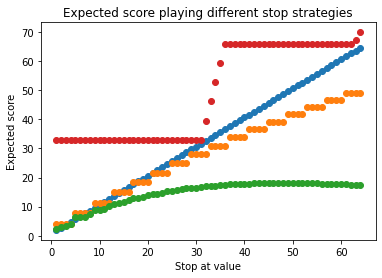

In [ ]:
def graph_generalized_pig_E(p_bust,v_advance):
  max_s = 64
  s_values = range(1,max_s+1)
  expected_score = [generalized_pig_E_and_P(s, p_bust, v_advance)[0] for s in s_values]

  plt.scatter(s_values, expected_score)
  plt.title('Expected score playing different stop strategies')
  plt.xlabel('Stop at value')
  plt.ylabel('Expected score')

# a bunch of different games we can graph
#graph_generalized_pig_E(1/6, np.array([0, 0, 1/5, 1/5, 1/5, 1/5, 1/5]))
#graph_generalized_pig_E(1/2, np.array([0, 1/8, 1/8, 1/8, 5/8, 0]))
graph_generalized_pig_E(0, np.array([0, 1/3, 1/3, 1/3, 0, 0]))
graph_generalized_pig_E(1/60, np.array([0, 0, 0, 0, 1]))
graph_generalized_pig_E(1/20, np.array([2/6, 0, 0, 1/6, 3/6]))
graph_generalized_pig_E(0, np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1/5,1/5,1/5,1/5,1/5]))

# Problem 5 - Simple Can't Stop Roll Again AI

## 5a Solution

In [ ]:
@jit
def prob_to_miss_targets(targets):
  '''Compute the probability to miss a list of target cols'''
  #Input:
  #  targets = a boolean array of shape (11,) with which are targets
  #Output:
  #  A real number with the probability to miss all the targets from targets when rolling 4 dice and pairing them

  #Create an array of shape (4,6,6,6,6) that contains all possible dice rolls
  #  i.e. the entry [:,a,b,c,d] = [a,b,c,d] is 4 dice rolls and a,b,c,d all run from 0 to 5
  four_dice_indices = jnp.indices((6,6,6,6)) 
 
  #Create an array with all 6 ways to choose 2 out of 4 dice
  #  Pairing 0 = choose dice 1 and dice 2
  #  Pairing 1 = choose dice 1 and dice 3 
  #  ... 
  #  Pairing 6 = choose dice 3 and dice 4
  pairing = jnp.array([[1,1,0,0],[1,0,1,0],[1,0,0,1],[0,1,1,0],[0,1,0,1],[0,0,1,1]])

  #Create an array of shape (6,6,6,6,6) which gives the value of the pairing 
  #  i.e. the (p,a,b,c,d) entry is the value of pairing p when the dice come up a,b,c,d
  four_dice_pairings = jnp.einsum("iabcd,ji->jabcd",four_dice_indices,pairing)
  
  #The same array, but of shape (6,6,6,6,11) now where it has been converted to a one hot encoding
  #  i.e. (p,a,b,c,d,:) is an array of shape (11,) with the one hot encoding of the pairing
  four_dice_pairings_one_hot = jnn.one_hot(four_dice_pairings,11)

  #A boolean array of shape (6,6,6,6,6)
  #  The (p,a,b,c,d) entry is k when the p-th pairing of a,b,c,d is hits the target list k times
  hit_target = jnp.einsum("pabcdk,k->pabcd",four_dice_pairings_one_hot,targets)

  #This is an array of shape (6,6,6,6) which is True when at least one of the pairings is in the target
  any_hit_target = jnp.any(hit_target > 0, axis=0)

  #Count the number of times we get a hit!
  number_of_dice_rolls_that_hit_target = jnp.count_nonzero(any_hit_target)

  #Convert count into a probability
  #  1296 = 6**4 is the total number of possible dice rolls
  return (1296- number_of_dice_rolls_that_hit_target)/1296

The can't stop bust probability when we are at the maximum number of runners is the probability to miss the columns that we have runners in. If we have not yet reached the maximum number of runners. We can hit any column that we have runners in or we can hit any legal column.

In [ ]:
def cant_stop_bust_probability(runner_col,illegal_col):
  #Purpose:
  #  Compute the bust_probability if we were to roll again in Can't Stop
  #Input:
  #  runner_col = an array of shape (11,) of integers with the runner locations
  #  illegal_col = an array of shape (11,) of boolean with which columns are illegal to play in 
  #NOTE:
  #  We assume N_Max_Runners = 3 for this one!

  N_Max_Runners = 3

  # the only targets when the max number of runners are in play are the columns with
  # runners in them
  if jnp.count_nonzero(runner_col) >= N_Max_Runners:
    return prob_to_miss_targets(runner_col)
  
  # if we havn't reached the max number of runners, we can play in any
  # column we have runners in, or legal columns
  return prob_to_miss_targets(jnp.logical_or(runner_col, 1-illegal_col))

## 5b Solution

**Recall:** In question 4, we found the optimal score strategy for *Generalized Pig*. We are going to use a similar approach for a simple don't stop AI. We found that the optimal roll strategy is to stop rolling when the **expected score** is less than or equal to the **current score**.

This works great because there is only one column we need to worry about. However, in *Can't Stop* there are multiple columns. So rather than thinking about **current score** and **expected score**, we will consider the **current progress** and **expected progress**:

* **current progress** is the sum of the progress of each runner.
* **expected progress** is the expected sum of the progress of each runner if we roll again.

We choose to roll again if **current progress** $<$ **expected progress**, otherwise we choose to end our turn.

To calculate the expected score in *Generalized Pig* we used the following formula:

\begin{align}
  \mathbb{E}(X_t) = (1-p_{bust})(\mathbb{E}(\text{roll}) + X_{t-1})
\end{align}

Where $X_t$ is the **score** at time $t$, $p_{bust}$ is the probability to go bust on any given roll, and $\mathbb{E}(\text{roll})$ is the **expected score** gained from any given roll.  We will use this formula in our *Can't Stop* AI, modified slightly for **expected progress** at time $t$. 

Let $p_{bust}$ be probabilty we go bust on any given roll in *Can't Stop*, and $X_{t}$ be the **current progress** at time $t$. Then,

\begin{align}
  \mathbb{E}(\text{X}_t) = (1-p_{bust})(\mathbb{E}(\text{roll}) + \text{X}_{t-1}) \tag{1}
\end{align}

Where, $\mathbb{E}(\text{roll}) = γ(1-p_{bust})$, $\gamma \in [1,2]$. $\mathbb{E}(\text{roll})$ is the **expected progress gained** on any given roll.

Note: $\gamma$ is some constant that represents the amount of progress that is made if we do not bust. In the case that we don't bust then we either progress by 1 or 2. Thus, the expected $\gamma$ is somewhere in the interval $[1,2]$. We could calculate the true $\gamma$ given the **runner_col** and **illegal_col**. But to get a nice solution we are going to **assume** that $\gamma = 1.33$. We can change $\gamma$ to make the AI play passively or aggressively. 


In [ ]:
def simple_roll_again_AI(runner_col, illegal_col, gamma=1.33, tests=False):
  #Purpose:
  #  Determine wheter or not to roll again or not in Can't stop given ONLY the current state of the runners and the illegal columns
  #  (Note: A better AI would take into account the player positions too, but we are making a very simple AI here)
  #Input:
  #  runner_col = an array of shape (11,) of integers with the runner locations
  #  illegal_col = an array of shape (11,) of boolean with which columns are illegal to play in 
  #NOTE:
  #  We assume N_Max_Runners = 3 for this one!

  # get the probability of bust
  p_bust = cant_stop_bust_probability(runner_col, illegal_col)

  # calculates the expected total progress after this roll as in equation (1)
  expt_prog = (1-p_bust)*(gamma*(1-p_bust) + np.sum(runner_col))

  # the total current progress made
  curr_prog = np.sum(runner_col)

  if tests:
    print("p_bust:", p_bust)
    print("expected:", expt_prog)
    print("current:", curr_prog)

  # if the expected progress after this roll is higher than the current progress
  # roll again! otherwise we stop rolling.
  if expt_prog > curr_prog:
    return 1
  else:
    return 0

simple_roll_again_AI(jnp.array([0, 0, 0, 0, 4, 0, 5, 0, 4, 0, 0]), jnp.array([0,0,0,0,0,0,0,0,0,0,0]), gamma=1.33, tests=True)

p_bust: 0.08873457
expected: 12.950889
current: 13


0

## Problem 5 - Tests
These are just some tests we did while working on this problem.

In [ ]:
def test_simple_roll_again_AI():

  # is we only have 1 runner in play and there are no illegal
  # columns, our AI should always roll.
  for i in range(1000):
    assert(simple_roll_again_AI(jnp.array([0, 0, 0, 0, i, 0, 0, 0, 0, 0, 0]), jnp.array([0,0,0,0,0,0,0,0,0,0,0])))
  
  # if we have runners only in low probability columns we should probably stop rolling
  assert(simple_roll_again_AI(jnp.array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]), jnp.array([0,0,0,0,0,0,0,0,0,0,0])) == 0)

  # if we have a 100% chance to bust we should probably stop rolling
  assert(simple_roll_again_AI(jnp.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), jnp.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])) == 0)

  # if we have a 0% chance to bust we should probably keep rolling
  assert(simple_roll_again_AI(jnp.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), jnp.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])))

test_simple_roll_again_AI()